In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import ray
import shutil
import sys
import torch

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tuner

ray.init(include_dashboard = False)

from ray.tune import choice
from ray.tune import uniform
from ray.tune import loguniform
from ray.tune import randint

2023-03-20 14:43:06,447	INFO worker.py:1538 -- Started a local Ray instance.


In [4]:
# Code

from source.python.dataset import dataset_utils
from source.python.raytune import raytune_model
from source.python.raytune import raytune_plot
from source.python.raytune import raytune_utils
from source.python.io      import loader
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [5]:
# Define output and inputs

MODEL_NAME       = 'zrimec2020'
MODEL_TYPE       = 'r'
MODEL_PARAMS     = None
MODEL_EPOCHS     = 5

TARGET_GROUP     = 'global'
TARGET_TYPE      = 'mean'
TARGET_EXPLODE   = False
TARGET_FILTER    = None

TUNER_CONCURRENT = 1
TUNER_TRIALS     = 5
TUNER_GRACE      = 1
TUNER_NOTEBOOK   = True

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)

	_groups = ['tissue', 'group', 'age', 'global', 'perturbation']
	_types  = ['mean', 'max']
	_models = ['washburn2019', 'zrimec2020']

	parser.add_argument('--target_group',     type = str,         default = 'global',     choices = _groups)
	parser.add_argument('--target_type',      type = str,         default = 'mean',       choices = _types)
	parser.add_argument('--model_name',       type = str,         default = 'zrimec2020', choices = _models)
	parser.add_argument('--target_explode',   type = str_of_bool, default = False)
	parser.add_argument('--target_filter',    type = str_or_none, default = None)
	parser.add_argument('--model_epochs',     type = int,         default = 500)
	parser.add_argument('--tuner_concurrent', type = int,         default = 5)
	parser.add_argument('--tuner_trials',     type = int,         default = 250)
	parser.add_argument('--tuner_grace',      type = int,         default = 5)

	args = vars(parser.parse_args())

	TARGET_GROUP     = args['target_group']
	TARGET_TYPE      = args['target_type']
	TARGET_EXPLODE   = args['target_explode']
	TARGET_FILTER    = args['target_filter']
	MODEL_NAME       = args['model_name']
	MODEL_EPOCHS     = args['model_epochs']
	TUNER_CONCURRENT = args['tuner_concurrent']
	TUNER_TRIALS     = args['tuner_trials']
	TUNER_GRACE      = args['tuner_grace']
	TUNER_NOTEBOOK   = False

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

Running as .ipynb


In [7]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp06-tuner', 'model', MODEL_NAME[:-4])
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\model\zrimec
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\model\zrimec\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [8]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 17.002 GB


In [9]:
# Load the input transcript features

sequence_bp2150 = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-bp2150.fasta'),
	to_string = True
)

feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base.npz')
)

# 2. Tuner

In [10]:
# Define basic data parameters

CONFIG = {
	'core/random'             : None,
	'core/device'             : DEVICE,
	'core/rootdir'            : ROOT,
	'core/outdir'             : OUT_DATA,
	'dataset/filepath'        : os.path.join(OUT_DATA, 'dataset.pkl'),
	'dataset/expanddim'       : None,
	'dataset/split/valid'     : 0.2,
	'dataset/split/test'      : 0.2,
	'tuner/trials'            : TUNER_TRIALS,
	'tuner/max_epochs'        : MODEL_EPOCHS,
	'tuner/min_epochs'        : TUNER_GRACE,
	'tuner/max_concurrent'    : TUNER_CONCURRENT,
	'tuner/reporter/freq'     : 30,
	'tuner/reporter/notebook' : TUNER_NOTEBOOK,
	'tuner/checkpoint'        : False,
	'tuner/stopper'           : True,
	'tuner/stopper/days'      : 3,
	'tuner/stopper/hours'     : 22,
	'tuner/stopper/minutes'   : 0,
	'model/name'              : MODEL_NAME,
	'model/type'              : MODEL_NAME + MODEL_TYPE,
	'model/epochs'            : MODEL_EPOCHS,
	'model/input/channels'    : 1,
	'model/input/height'      : 4,
	'model/input/width'       : 2150,
	'model/input/features'    : None,
	'model/output/target'     : TARGET_GROUP,
	'model/output/type'       : TARGET_TYPE,
	'model/output/filter'     : TARGET_FILTER,
	'model/output/explode'    : TARGET_EXPLODE,
	'model/output/size'       : None,
	'params/tuner'            : None,
	'params/filepath'         : RES_TUNER
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

if CONFIG['model/name'].startswith('washburn2019') :
	CONFIG['dataset/expanddim'] = 0

In [11]:
# Prints

print('Model Name  : {}'.format(CONFIG['model/name']))
print('Model Type  : {}'.format(CONFIG['model/type']))
print('Random Seed : {}'.format(CONFIG['core/random']))

Model Name  : zrimec2020
Model Type  : zrimec2020r
Random Seed : 737850287


# 3. Dataset

In [12]:
# Load features

filters = {
	'tissue'       : None,
	'group'        : None,
	'age'          : None,
	'perturbation' : None,
	'global'       : None,
} | {
	TARGET_GROUP : TARGET_FILTER
	if TARGET_FILTER is None
	else [TARGET_FILTER]
}

dataframe, target_value, target_order = loader.load_feature_targets(
	group     = '{}-{}'.format(TARGET_GROUP, TARGET_TYPE),
	explode   = TARGET_EXPLODE,
	filters   = filters,
	directory = RES_NBP05,
	filename  = 'mapping-grouped.pkl',
	mode      = 'regression'
)

if 'Feature' in dataframe.columns :
	feature_base = {
		key : numpy.concatenate((feature_base[key.split('?')[-1]], value))
		for key, value in dataframe['Feature'].to_dict().items()
	}

CONFIG['model/output/size']    = len(target_order)
CONFIG['model/input/features'] = len(list(feature_base.values())[0])

dataframe

,Transcript,TPM_Value,TPM_Label,Global
AT1G01010.1,AT1G01010.1,[1.761241756101558],[1],[global]
AT1G01020.1,AT1G01020.1,[1.0866479101651763],[0],[global]
AT1G01030.1,AT1G01030.1,[1.0235488805181145],[0],[global]
AT1G01040.1,AT1G01040.1,[1.6519999764364053],[1],[global]
AT1G01050.1,AT1G01050.1,[3.2601375485355275],[2],[global]
...,...,...,...,...
AT5G67600.1,AT5G67600.1,[3.2010419178026743],[2],[global]
AT5G67610.1,AT5G67610.1,[1.8563512356941414],[1],[global]
AT5G67620.1,AT5G67620.1,[0.9904034477856412],[0],[global]
AT5G67630.1,AT5G67630.1,[2.4249098838660283],[2],[global]


In [13]:
# Create dataset

dataset = dataset_utils.to_gene_dataset(
	sequences   = sequence_bp2150,
	features    = feature_base,
	targets     = target_value,
	expand_dims = CONFIG['dataset/expanddim']
)

In [14]:
# Save dataset

torch.save(dataset, CONFIG['dataset/filepath'])

In [15]:
# Assert all is set

if CONFIG['dataset/filepath']     is None : raise AssertionError('dataset/filepath')
if CONFIG['model/input/features'] is None : raise AssertionError('model/input/features')
if CONFIG['model/output/size']    is None : raise AssertionError('model/output/size')

print('Dataset Filepath : {}'.format(CONFIG['dataset/filepath']))
print('Input Features   : {}'.format(CONFIG['model/input/features']))
print('Output Size      : {}'.format(CONFIG['model/output/size']))

Dataset Filepath : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\model\zrimec\dataset.pkl
Input Features   : 72
Output Size      : 1


# 4. Search Space

In [16]:
# Define optimizer parameters

optimizer_lr       = loguniform(1e-5, 1e-2)
optimizer_decay    = uniform(0.000, 0.100)
optimizer_beta1    = uniform(0.500, 0.950)
optimizer_beta2    = uniform(0.951, 0.999)

In [17]:
# Define scheduler parameters

scheduler_name             = choice(['plateau', 'linear', 'exponential'])
scheduler_plateau_factor   = uniform(0.1, 0.5)
scheduler_plateau_patience = randint(5, 25)
scheduler_linear_factor    = uniform(1e-07, 2e-01)
scheduler_exp_factor       = uniform(0.900, 0.999)

In [18]:
# Define model parameters

model_dropout   = uniform(0.0, 0.5)
model_leakyrelu = uniform(0.0, 0.1)

conv1_kernels  = [5, 11, 21, 31, 41]
conv1_filters  = [32, 64, 128, 256]

convx_kernels  = [5, 11, 21, 31, 41]
convx_padding  = ['same', 'none']
convx_filters  = [32, 64, 128, 256]
convx_dilation = [1]

poolx_kernels  = [3, 5, 9]
poolx_padding  = ['same', 'none']

fc1_features = [64, 128, 256, 512]
fcx_features = [64, 128, 256, 512]

In [19]:
# Define search space (tested with zrimec2020r and washburn2019r)

param_space = dict()

# Dataset
param_space['dataset/batch_size'] = choice([32, 64, 128])

# Optimizer
param_space['optimizer/name']  = 'adam'
param_space['optimizer/lr']    = optimizer_lr
param_space['optimizer/decay'] = optimizer_decay
param_space['optimizer/beta1'] = optimizer_beta1
param_space['optimizer/beta2'] = optimizer_beta2

# Criterion
param_space['criterion/name']      = 'mse'
param_space['criterion/reduction'] = 'mean'

# Scheduler
param_space['scheduler/name']               = scheduler_name
param_space['scheduler/plateau/factor']     = scheduler_plateau_factor
param_space['scheduler/plateau/patience']   = scheduler_plateau_patience
param_space['scheduler/linear/factor']      = scheduler_linear_factor
param_space['scheduler/exponential/factor'] = scheduler_exp_factor

# Model
param_space['model/dropout']   = model_dropout
param_space['model/leakyrelu'] = model_leakyrelu

# Convolution
param_space['model/conv1/filters']  = choice(conv1_filters)
param_space['model/conv1/kernel']   = choice(conv1_kernels)
param_space['model/conv1/padding']  = 'none'
param_space['model/conv1/dilation'] = 1
param_space['model/conv2/filters']  = choice(convx_filters)
param_space['model/conv2/kernel']   = choice(convx_kernels)
param_space['model/conv2/padding']  = 'same'
param_space['model/conv2/dilation'] = 1
param_space['model/conv3/filters']  = choice(convx_filters)
param_space['model/conv3/kernel']   = choice(convx_kernels)
param_space['model/conv3/padding']  = 'same'
param_space['model/conv3/dilation'] = 1

if CONFIG['model/name'].startswith('washburn2019') :
	param_space['model/conv4/filters']  = choice(convx_filters)
	param_space['model/conv4/kernel']   = choice(convx_kernels)
	param_space['model/conv4/padding']  = 'same'
	param_space['model/conv4/dilation'] = 1
	param_space['model/conv5/filters']  = choice(convx_filters)
	param_space['model/conv5/kernel']   = choice(convx_kernels)
	param_space['model/conv5/padding']  = 'same'
	param_space['model/conv5/dilation'] = 1
	param_space['model/conv6/filters']  = choice(convx_filters)
	param_space['model/conv6/kernel']   = choice(convx_kernels)
	param_space['model/conv6/padding']  = 'same'
	param_space['model/conv6/dilation'] = 1

# Pooling
param_space['model/maxpool1/kernel']  = choice(poolx_kernels)
param_space['model/maxpool1/padding'] = 'same'
param_space['model/maxpool2/kernel']  = choice(poolx_kernels)
param_space['model/maxpool2/padding'] = 'same'
param_space['model/maxpool3/kernel']  = choice(poolx_kernels)
param_space['model/maxpool3/padding'] = 'same'

# Linear
param_space['model/fc1/features'] = choice(fc1_features)
param_space['model/fc2/features'] = choice(fcx_features)

In [20]:
# Define starting parameters for algorithm (some decent starting point from previous runs)

params_initial = None

if CONFIG['model/type'].startswith('zrimec2020r') :
	filename = os.path.join(RES_TUNER, 'zrimec2020.json')

	if os.path.exists(filename) :
		params_initial = loader.load_json(filename = filename)

if CONFIG['model/type'].startswith('washburn2019r') :
	filename = os.path.join(RES_TUNER, 'washburn2019.json')

	if os.path.exists(filename) :
		params_initial = loader.load_json(filename = filename)

# 5. Tuning

In [21]:
# Create tuner config

trainable = raytune_utils.create_trainable(
	method = raytune_model.main,
	config = CONFIG,
	cpu_count = SYSTEM['platform/cpu/count'],
	gpu_count = SYSTEM['platform/gpu/count']
)

tune_config = raytune_utils.create_tune_config(
	config = CONFIG,
	params = params_initial
)

run_config = raytune_utils.create_run_config(
	config    = CONFIG,
	local_dir = OUT_DATA,
	verbosity = raytune_utils.VERBOSE_STATUS,
	mode      = 'regression'
)

In [22]:
# Create tune and fit

tuner = raytune_utils.create_tuner(
	trainable   = trainable,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-03-20 14:54:01,197	INFO tune.py:762 -- Total run time: 565.65 seconds (562.38 seconds for the tuning loop).


# 6. Reports

In [23]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [24]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

print()

valid_loss                               valid_r2                                 valid_mae                                
valid_mape                               valid_wmape                              train_loss                               
train_r2                                 train_mae                                train_mape                               
train_wmape                              lr                                       time_this_iter_s                         
done                                     timesteps_total                          episodes_total                           
training_iteration                       trial_id                                 experiment_id                            
date                                     timestamp                                time_total_s                             
pid                                      hostname                                 node_ip                                  
time_sin

In [25]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

trials = dataframe[[
	'trial_id', 'logdir', 'time_total_s', 'training_iteration',
	'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
	'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
]]

trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :      0.4 minutes
 Longest training time :      4.3 minutes
   Total training time :      8.7 minutes
    Mean training time :      1.7 minutes



,trial_id,logdir,time_total_s,training_iteration,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
1,51fe720f,C:\Developer\Workspace\PyCharm\Projects\upolan...,257.077,5,0.576,0.334,0.616,1.394,0.357,0.863,-0.020,0.757,1.727,0.437
0,5f0507ff,C:\Developer\Workspace\PyCharm\Projects\upolan...,163.372,5,0.699,0.181,0.683,1.516,0.397,1.498,-0.796,1.003,0.887,0.576
3,81192a93,C:\Developer\Workspace\PyCharm\Projects\upolan...,47.124,1,1.746,-1.123,1.037,1.934,0.605,1.581,-0.928,1.029,1.065,0.590
4,b87d60df,C:\Developer\Workspace\PyCharm\Projects\upolan...,21.624,1,4.769,-4.570,1.727,3.027,1.003,1.915,-1.255,1.116,1.474,0.642
2,d8848fc5,C:\Developer\Workspace\PyCharm\Projects\upolan...,32.778,1,2.719,-2.180,1.143,2.095,0.660,6.149,-6.345,2.284,2.330,1.314


In [26]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, 'report.csv')
)

## 6.1 Visualization

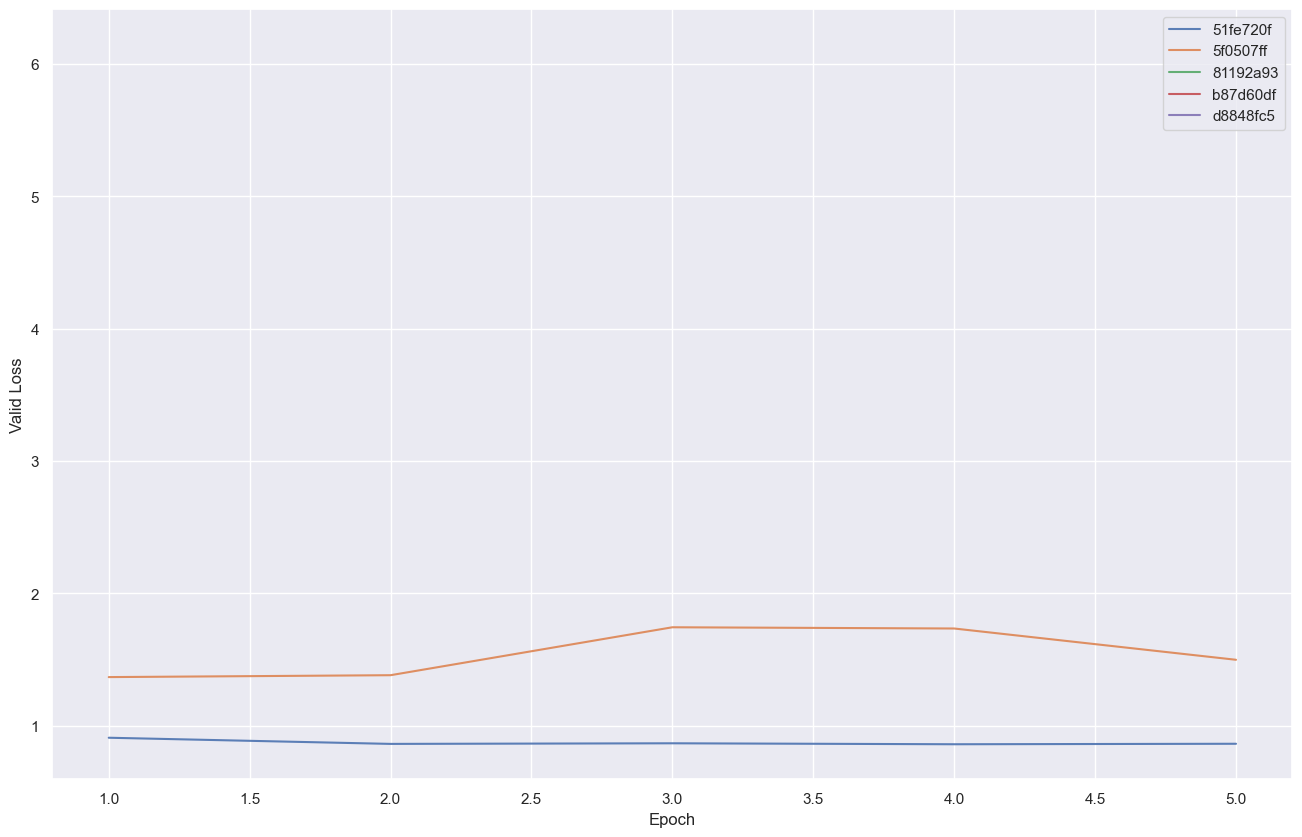

In [27]:
# Plot trials valid loss

raytune_plot.trials_lineplot_loss(
	dataframe  = trials,
	max_trials = 5,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

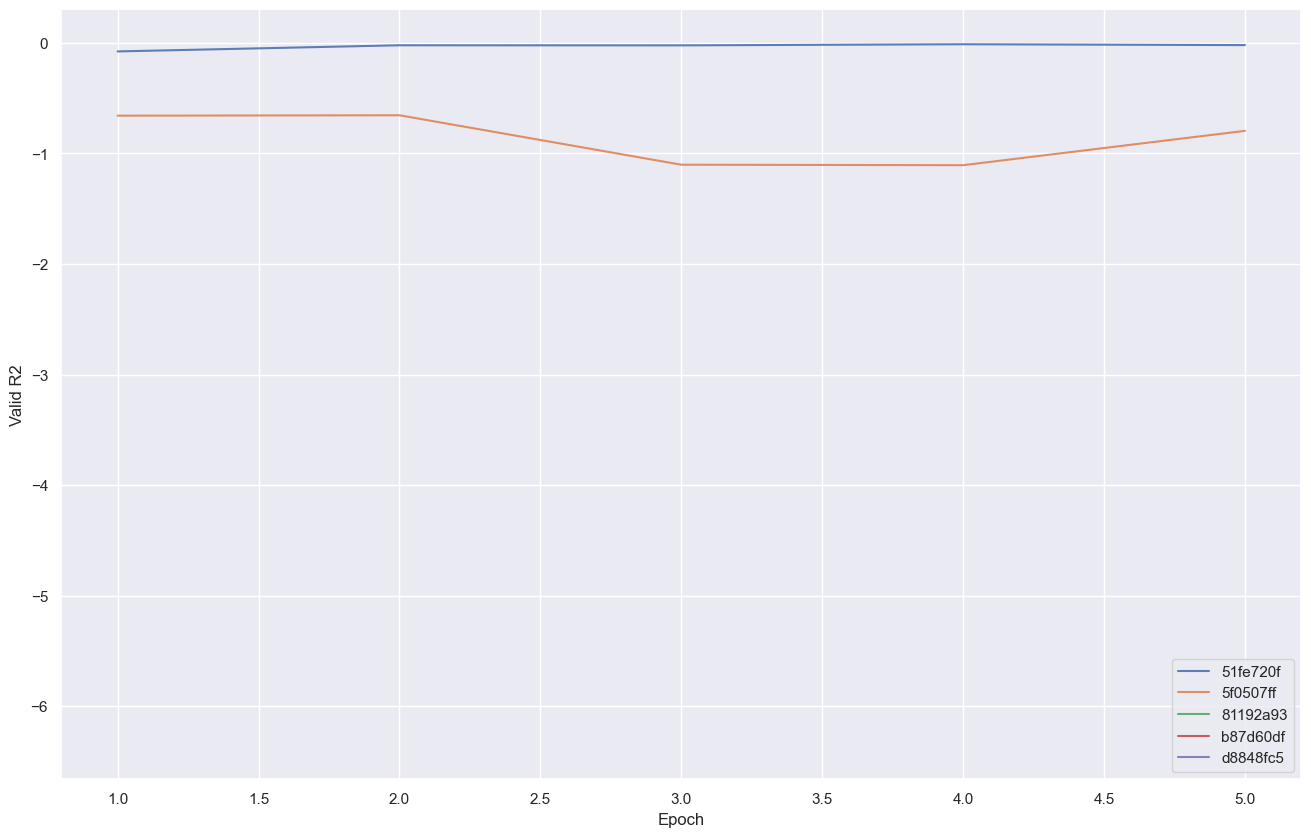

In [28]:
# Plot trials valid r2

raytune_plot.trials_lineplot_r2(
	dataframe  = trials,
	max_trials = 5,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

## 6.2 Best

In [29]:
# Display best trial

best = report.get_best_result()

print('Best metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(best.metrics['valid_loss'], best.metrics['valid_r2']))
print('Best config : ')

for key, val in best.config.items() :
	if isinstance(key, str) : key = f'"{key}"'
	if isinstance(val, str) : val = f'"{val}"'

	print('{:30s} : {}'.format(key, val))

Best metric : loss =  0.86338 r2 = -0.01992
Best config : 
"dataset/batch_size"           : 128
"optimizer/name"               : "adam"
"optimizer/lr"                 : 2.451860301373e-05
"optimizer/decay"              : 0.0464052533000238
"optimizer/beta1"              : 0.5365792171661639
"optimizer/beta2"              : 0.999
"criterion/name"               : "mse"
"criterion/reduction"          : "mean"
"scheduler/name"               : "linear"
"scheduler/plateau/factor"     : 0.3319740691249563
"scheduler/plateau/patience"   : 6
"scheduler/linear/factor"      : 0.0260499850842293
"scheduler/exponential/factor" : 0.9128417486818478
"model/dropout"                : 0.0
"model/leakyrelu"              : 0.0
"model/conv1/filters"          : 128
"model/conv1/kernel"           : 21
"model/conv1/padding"          : "none"
"model/conv1/dilation"         : 1
"model/conv2/filters"          : 64
"model/conv2/kernel"           : 41
"model/conv2/padding"          : "same"
"model/conv2/dilation" 

In [30]:
# Display per iteration

progress = loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

progress = trials = progress[[
	'trial_id', 'time_total_s', 'training_iteration', 'lr',
	'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
	'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
]]

progress

,trial_id,time_total_s,training_iteration,lr,train_loss,train_r2,train_mae,train_mape,train_wmape,valid_loss,valid_r2,valid_mae,valid_mape,valid_wmape
0,51fe720f,54.798,1,0.000,1.180,-0.361,0.871,1.938,0.504,0.909,-0.077,0.780,1.753,0.450
1,51fe720f,104.239,2,0.000,0.819,0.050,0.741,1.719,0.430,0.862,-0.021,0.762,1.670,0.438
2,51fe720f,153.021,3,0.000,0.732,0.153,0.698,1.604,0.405,0.867,-0.022,0.762,1.830,0.439
3,51fe720f,205.330,4,0.000,0.652,0.244,0.657,1.492,0.381,0.860,-0.012,0.756,1.662,0.435
4,51fe720f,257.077,5,0.000,0.576,0.334,0.616,1.394,0.357,0.863,-0.020,0.757,1.727,0.437


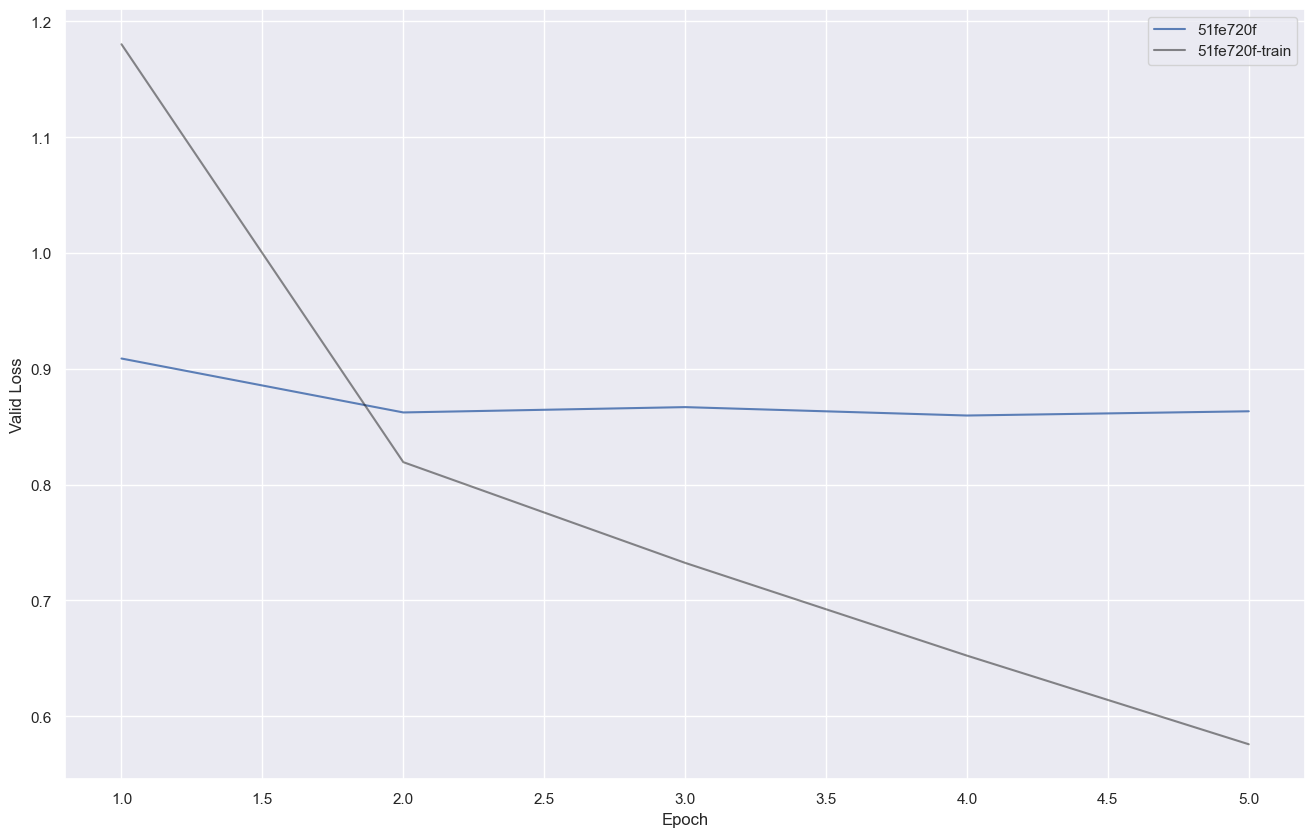

In [31]:
# Plot best trial valid loss

raytune_plot.trial_lineplot_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

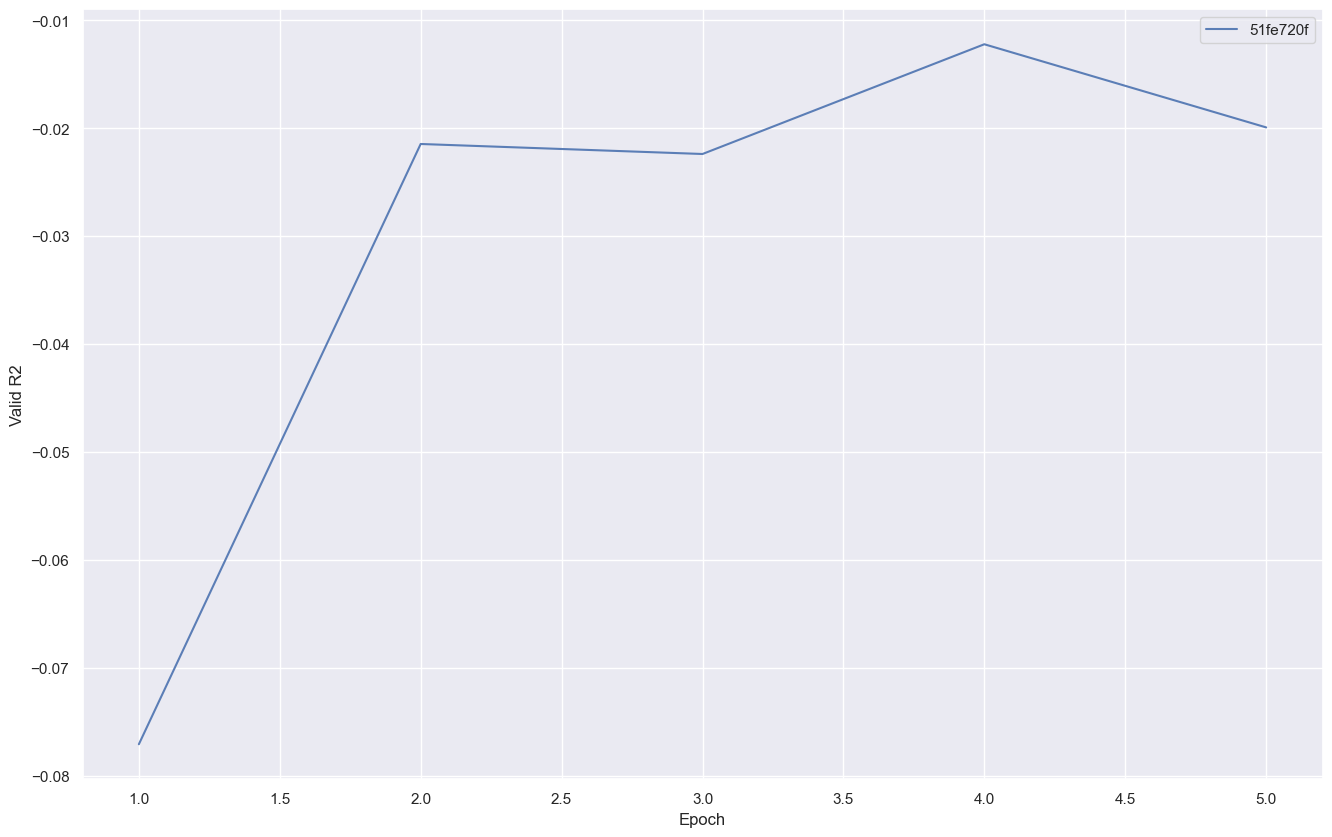

In [32]:
# Plot best trial valid r2

raytune_plot.trial_lineplot_r2(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

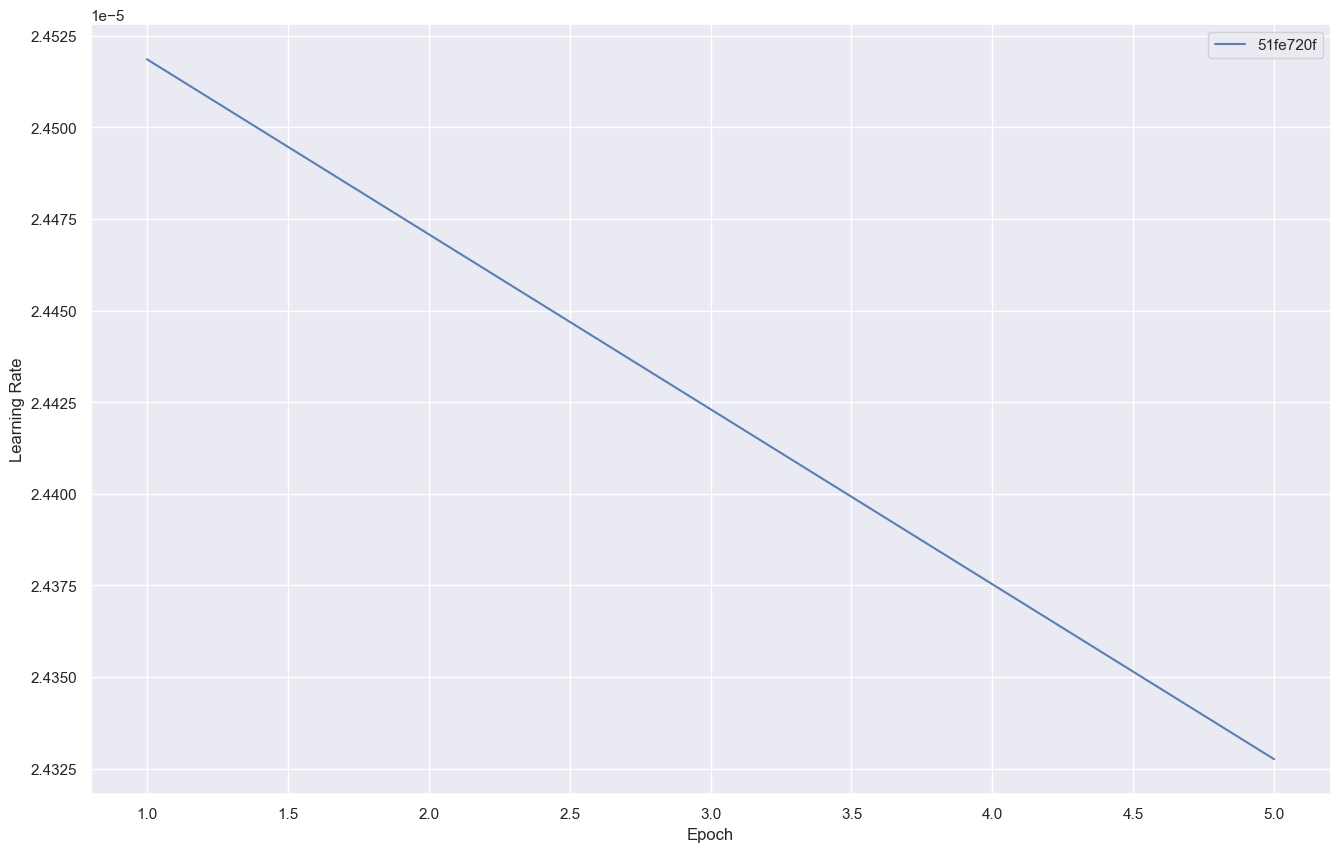

In [33]:
# Plot trials learning rate

raytune_plot.trial_lineplot_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)